# 実験条件

# Import

In [1]:
# Python
import sys
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime as dt
import matplotlib.pyplot as plt

sys.path.append('../tools')
import dataset

Importing plotly failed. Interactive plots will not work.


# Dataset

## Read

In [2]:
target_cols = [
    'Industrial_robots', 
    'Pneumatic_and_hydraulic_equipment',
    'materialshandling_machinery',
    'Metal_working_machinery',
    'Refrigerating_machines',
    'Plastics_pocessing_machinery',
    'stock'
]

crate_df = dataset.CreateTimeSeriesData(target_cols)
crate_df.create_base_df() #ベースマートの作成実行

df_original = crate_df.create_original_df_pipeline()
df_log = crate_df.create_log_df_pipeline()

## Preprocessing

In [3]:
def preprocessing_df(df_original: pd.DataFrame, target_col: str) -> pd.DataFrame:
  """Prophetモデル投入用にデータを前処理"""

  # df_originalを転置して時間情報(ds)の列を定義
  df_original_t = df_original.T
  df_original_t.reset_index(inplace= True)
  df_original_t = df_original_t.rename(columns={'index': 'ds'}) 

  # 時間情報(ds)をdatetime型に変換
  df_original_t['ds'] = pd.to_datetime(df_original_t['ds'], format='%Y年%m月')
  
  # 指定日付（2026年6月）以前のデータを抽出
  cutoff_date = pd.Timestamp('2023-06-30')  # 6月の最終日を指定
  df_original_t = df_original_t[df_original_t['ds'] <= cutoff_date]

  # 予測対象の時系列指標のカラム名を 'y'に変更
  df_original_t = df_original_t.rename(columns={target_col: 'y'})

  return df_original_t

# Predict

In [4]:
models = []
preds = []
forecasts = []

for target_col in target_cols:

    # 学習データを用意
    df = preprocessing_df(df_original, target_col)

    # 学習    
    model = Prophet()
    model.fit(df)

    # 予測値を格納するためのDataFrameを作成し、予測を実施
    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)
    forecasts.append(forecast)
    models.append(model)

    # 23年7月・8月予測値をpredへ格納
    tmp = forecast[forecast['ds'].isin(['2023-07-01','2023-08-01'])]
    pred = tmp['yhat'].to_numpy()
    preds.append(pred)
   
# predsをリスト型からnp.vstackで結合して変換
preds_arr = np.vstack(preds)

00:05:17 - cmdstanpy - INFO - Chain [1] start processing
00:05:17 - cmdstanpy - INFO - Chain [1] done processing
00:05:18 - cmdstanpy - INFO - Chain [1] start processing
00:05:18 - cmdstanpy - INFO - Chain [1] done processing
00:05:19 - cmdstanpy - INFO - Chain [1] start processing
00:05:19 - cmdstanpy - INFO - Chain [1] done processing
00:05:19 - cmdstanpy - INFO - Chain [1] start processing
00:05:19 - cmdstanpy - INFO - Chain [1] done processing
00:05:20 - cmdstanpy - INFO - Chain [1] start processing
00:05:20 - cmdstanpy - INFO - Chain [1] done processing
00:05:20 - cmdstanpy - INFO - Chain [1] start processing
00:05:20 - cmdstanpy - INFO - Chain [1] done processing
00:05:21 - cmdstanpy - INFO - Chain [1] start processing
00:05:21 - cmdstanpy - INFO - Chain [1] done processing


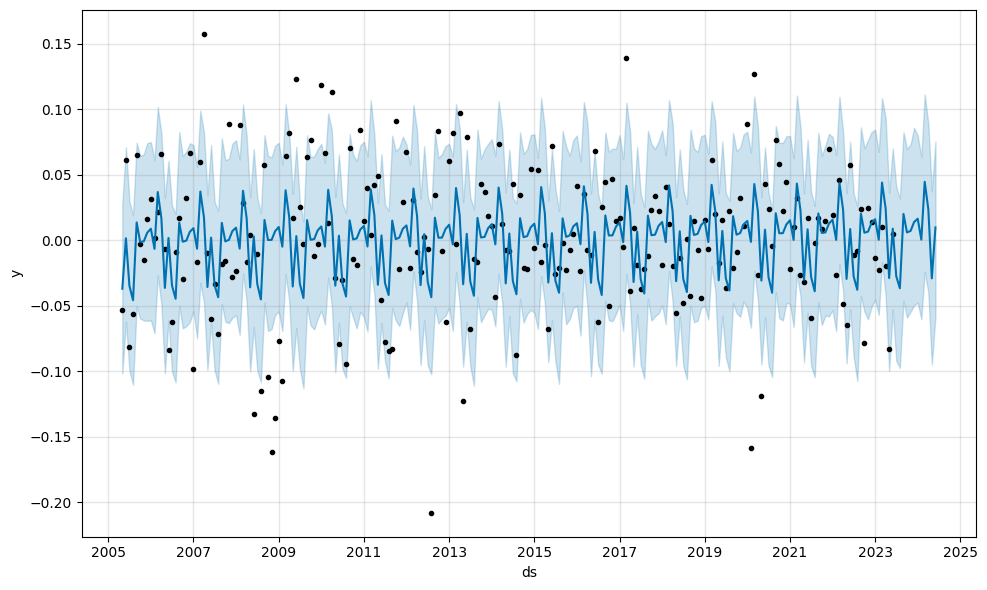

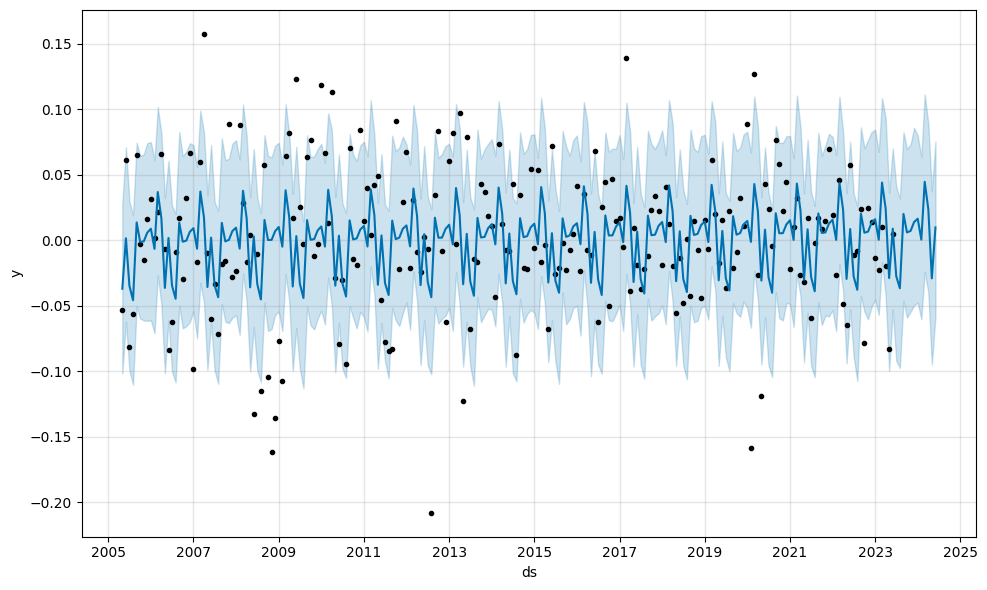

In [5]:
models[0].plot(forecasts[0])

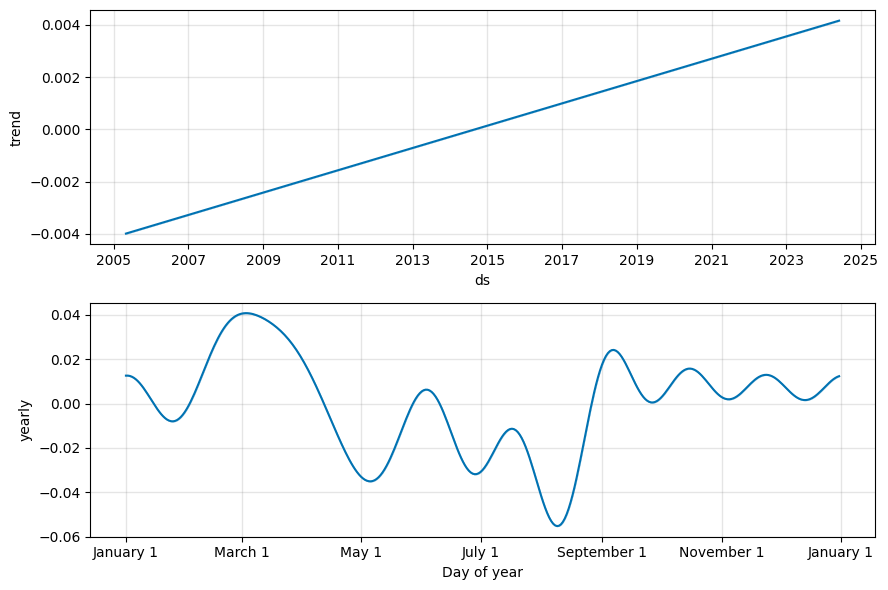

In [6]:
models[0].plot_components(forecasts[0])
plt.show()

# Evaluate

In [7]:
# 23年6月の実績を取得
act_2306_arr = df_log['2023年6月'].to_numpy()
act_2306_arr = act_2306_arr.reshape(-1,1)

# 7月のデータを計算
pred_2307_arr = act_2306_arr + preds_arr[:, 0:1]  # 列のスライスに注意
# 8月のデータを計算
pred_2308_arr = pred_2307_arr + preds_arr[:, 1:2]  # 列のスライスに注意

# 結果を取りまとめて出力
result_arr = np.concatenate([act_2306_arr,pred_2307_arr,pred_2308_arr],1)
result = pd.DataFrame(result_arr, columns=['2023年6月', '2023年7月', '2023年8月'], index=target_cols)

In [8]:
result

,2023年6月,2023年7月,2023年8月
Industrial_robots,4.693490,4.666118,4.629525
Pneumatic_and_hydraulic_equipment,5.050391,5.009744,5.017544
materialshandling_machinery,5.036481,4.989594,4.963221
Metal_working_machinery,4.422934,4.392814,4.316231
Refrigerating_machines,4.741467,4.724426,4.621964
Plastics_pocessing_machinery,4.427275,4.419422,4.404297
stock,4.520995,4.524964,4.522599
